In [1]:
import tensorflow as tf
tf.__version__

'2.5.0'

In [2]:
import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.models import Model,Sequential
import matplotlib.pyplot as plt
import numpy as np
import math

##   Data Preprocessing and Augmentation
In Keras this can be done via the `keras.preprocessing.image.ImageDataGenerator` class. This class allows you to:

1. configure random transformations and normalization operations to be done on your image data during training
2. instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. These generators can then be used with the Keras model methods that accept data generators as inputs, fit_generator, evaluate_generator and predict_generator.
<br>

<font size = 4> [ref link for flowfromdirectory-method](https://keras.io/api/preprocessing/image/#flowfromdirectory-method)


* rotation_range is a value in degrees (0-180), a range within which to randomly rotate pictures
* width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally
* rescale is a value by which we will multiply the data before any other processing. Our original images consist in RGB coefficients in the 0-255, but such values would be too high for our models to process (given a typical learning rate), so we target values between 0 and 1 instead by scaling with a 1/255. factor.
* shear_range is for randomly applying shearing transformations
* zoom_range is for randomly zooming inside pictures
* horizontal_flip is for randomly flipping half of the images horizontally --relevant when there are no assumptions of horizontal assymetry (e.g. real-world pictures).
* fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

In [3]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('G:/Jupyter_ML_folder/CNN/DevanagariHandwrittenCharacterDataset/Train/digit_2/4885.png')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='G:/Jupyter_ML_folder/CNN/preview', save_prefix='dig2', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

<font size = 3>We start with the first line of the code that specifies the batch size. We have set it to 32 which means that one batch of image will have 32 images stacked together in tensor. The shape of this array would be (batch_size, image_y, image_x, channels). This is a channels last approach i.e. the number of channels are in the last dimension.

In [4]:
batch_size = 32
# example of progressively loading images from file
from keras.preprocessing.image import ImageDataGenerator

#### create generator
#  this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

#  this is the augmentation configuration we will use for testing
test_datagen = ImageDataGenerator(rescale = 1./255)

# prepare an iterators for each dataset
train_it = train_datagen.flow_from_directory('G:/Jupyter_ML_folder/CNN/DevanagariHandwrittenCharacterDataset/Train',
                                       target_size = (32,32), batch_size = batch_size,
                                       class_mode='categorical')
test_it = test_datagen.flow_from_directory('G:/Jupyter_ML_folder/CNN/DevanagariHandwrittenCharacterDataset/Test',
                                      target_size = (32,32), batch_size = batch_size, 
                                      class_mode='categorical')


# confirm the iterator works
batchX_train, batchy_train = train_it.next()
batchX_test, batchy_test = test_it.next()
print('Train Batch shape=%s, min=%.3f, max=%.3f' % (batchX_train.shape, batchX_train.min(), batchX_train.max()))
print('Test Batch shape=%s, min=%.3f, max=%.3f' % (batchX_test.shape, batchX_test.min(), batchX_test.max()))

Found 78200 images belonging to 46 classes.
Found 13800 images belonging to 46 classes.
Train Batch shape=(32, 32, 32, 3), min=0.000, max=1.000
Test Batch shape=(32, 32, 32, 3), min=0.000, max=1.000


20


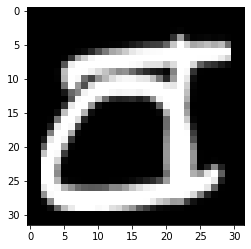

In [5]:
print(np.argmax(batchy_test[1]))
x = np.squeeze(tf.image.rgb_to_grayscale(batchX_test[1]))
plt.imshow(x,cmap='gray')
# batchX_test[0].shape

## Designing a variation of LeNet-5
* with ReLU activations

In [6]:
def LeNet( input_shape):
  inputs = tf.keras.Input(shape = input_shape)

  # Block 1 : CONV => POOL
  x = layers.Conv2D(6,kernel_size=5,activation='relu',
                   input_shape = input_shape, name = 'conv_layer1')(inputs)

  x = layers.MaxPooling2D(pool_size=(2,2),strides=2,
                             name = 'avg_pool1')(x)
  # Block 2  : CONV => POOL
  x = layers.Conv2D(16,kernel_size=5,activation='relu',
                   name = 'conv_layer2')(x)

  x = layers.MaxPooling2D(pool_size=(2,2),strides=2,
                             name = 'avg_pool2')(x)

  # Block 3  : CONV 
  x = layers.Conv2D(120,kernel_size=5,activation='relu',
                    name = 'conv_layer3')(x)

  x = layers.Flatten()(x)

  # Block 4  : FC1 => FC2 => SOFTMAX
  x = layers.Dense(120,activation='relu',name = 'fc1')(x)
  x = layers.Dense(84,activation='relu',name = 'fc2')(x)
  x = layers.Dense(46,activation='softmax',name = 'o/p')(x)

  # making model
  model = tf.keras.Model(inputs = inputs,outputs = x ,name="LeNet-5")
  model.summary()
  return model

In [7]:
model_lenet = LeNet(input_shape=(32,32,3))

Model: "LeNet-5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv_layer1 (Conv2D)         (None, 28, 28, 6)         456       
_________________________________________________________________
avg_pool1 (MaxPooling2D)     (None, 14, 14, 6)         0         
_________________________________________________________________
conv_layer2 (Conv2D)         (None, 10, 10, 16)        2416      
_________________________________________________________________
avg_pool2 (MaxPooling2D)     (None, 5, 5, 16)          0         
_________________________________________________________________
conv_layer3 (Conv2D)         (None, 1, 1, 120)         48120     
_________________________________________________________________
flatten (Flatten)            (None, 120)               0   

In [10]:
model_lenet.compile(loss='categorical_crossentropy'
                    ,optimizer= 'rmsprop',metrics = ['accuracy'])

**When we call the .fit() function it makes assumptions:**

* The entire training set can fit into the Random Access Memory (RAM) of the computer.
* Calling the model. fit method for a second time is not going to reinitialize our already trained weights, which means we can actually make consecutive calls to fit if we want to and then manage it properly.
* There is no need for using the Keras generators(i.e no data argumentation)
* Raw data is itself used for training our network and our raw data will only fit into the memory.

**When we call the .fit_generator() function it makes assumptions:**

* Keras is first calling the generator function(dataAugmentaion)
* Generator function(dataAugmentaion) provides a batch_size of 32 to our .fit_generator() function.
* our .fit_generator() function first accepts a batch of the dataset, then performs backpropagation on it, and then updates the weights in our model.
* For the number of epochs specified the process is repeated.

In [11]:
model_lenet.fit_generator(train_it, 
                         steps_per_epoch= math.ceil(78200 / batch_size),
                         epochs=5,
                         validation_data=test_it,
                         validation_steps= math.ceil(13800 / batch_size))

Epoch 1/5
2444/2444 [==============================] - 202s 82ms/step - loss: 1.2648 - accuracy: 0.6343 - val_loss: 0.5300 - val_accuracy: 0.8412
Epoch 2/5
2444/2444 [==============================] - 87s 35ms/step - loss: 0.5653 - accuracy: 0.8267 - val_loss: 0.3603 - val_accuracy: 0.8864
Epoch 3/5
2444/2444 [==============================] - 86s 35ms/step - loss: 0.4300 - accuracy: 0.8677 - val_loss: 0.3229 - val_accuracy: 0.9007
Epoch 4/5
2444/2444 [==============================] - 88s 36ms/step - loss: 0.3609 - accuracy: 0.8884 - val_loss: 0.3036 - val_accuracy: 0.9086
Epoch 5/5
2444/2444 [==============================] - 84s 34ms/step - loss: 0.3245 - accuracy: 0.9007 - val_loss: 0.2654 - val_accuracy: 0.9208


### Saving weights of model (or) Model itself to be Loaded Next Time
> so we don't have to fit every time
> * `save_weights` ,to Create a model and losd weights
> * `model.save` to directly load model

In [12]:
# always save your weights after training or during training
model_lenet.save_weights('first_try_lenet.h5')  

# # Loading Weights
# saved_model_load = LeNet(input_shape=(32,32,3))
# saved_model_load.load_weights('G:/Jupyter_ML_folder/CNN/first_try.h5')
# saved_model_load

In [13]:
# Saving Model itself
model_lenet.save('LeNet_Model.h5')

# # Loading Model itself
# model_load_lenet = tf.keras.models.load_model('G:/Jupyter_ML_folder/CNN/LeNet_Model.h5')

**<font size=3> Architecture of LeNet-5 Model shown below**

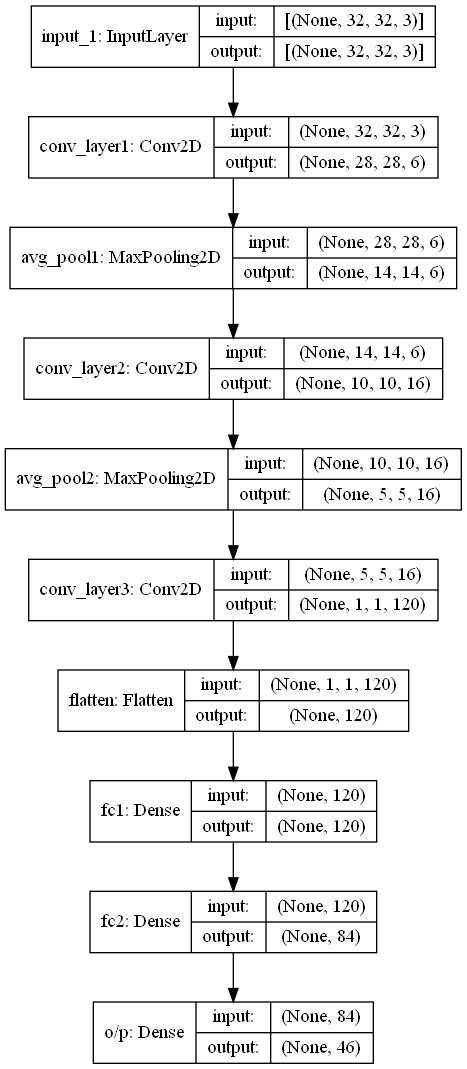

In [14]:
dot_img_file = 'G:/Jupyter_ML_folder/CNN/LeNet_Model.png'
tf.keras.utils.plot_model(model_lenet, to_file=dot_img_file, show_shapes=True)

### Predicting from model

In [42]:
test_it.reset()  #resetting iterator to initial position
    
y_hat = model_lenet.predict_generator(test_it,
                             steps= math.ceil(13800 / batch_size))

y_hat.shape

(13800, 46)

### Confusion Matrix

In [20]:
import sklearn.metrics

# 1.Predict classes ang get most likely classes
predicted_class = np.argmax(y_hat,axis = 1)
predicted_class

# 2.Get ground-truth classes and class-labels
true_classes = test_it.classes
class_labels = list(test_it.class_indices.keys()) 

# 3. Use scikit-learn to get statistics
report = sklearn.metrics.classification_report(true_classes, predicted_class, target_names=class_labels)
print(report)

                           precision    recall  f1-score   support

         character_10_yna       0.03      0.03      0.03       300
    character_11_taamatar       0.03      0.03      0.03       300
        character_12_thaa       0.02      0.02      0.02       300
         character_13_daa       0.02      0.02      0.02       300
        character_14_dhaa       0.03      0.03      0.03       300
        character_15_adna       0.02      0.02      0.02       300
      character_16_tabala       0.02      0.02      0.02       300
         character_17_tha       0.02      0.03      0.03       300
          character_18_da       0.02      0.02      0.02       300
         character_19_dha       0.03      0.03      0.03       300
           character_1_ka       0.01      0.01      0.01       300
          character_20_na       0.03      0.02      0.02       300
          character_21_pa       0.05      0.05      0.05       300
         character_22_pha       0.04      0.04      0.04     

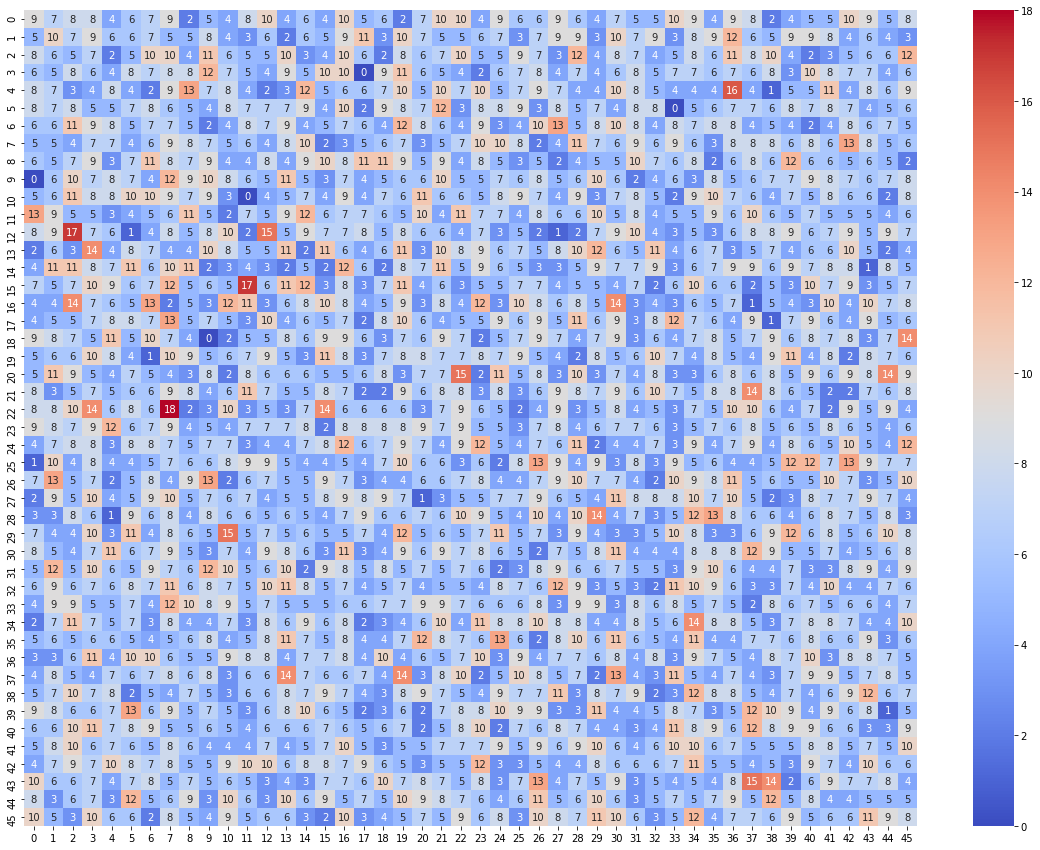

In [21]:
import seaborn as sns
np.set_printoptions(threshold=np.inf)

cm = sklearn.metrics.confusion_matrix(true_classes,predicted_class)

plt.figure(figsize=(20,15))
sns.heatmap(cm,annot = True,fmt='g',cmap = 'coolwarm')
plt.show()

> Pretty terrible performance for a DL model even though accuracy is around 90%